In [936]:
import pandas as pd
import sqlite3
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import csv
from scipy.stats.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


In [937]:
# Data Directory
data_dir = "../../Data/Big-Data-Cup-2021"
bucketless_data_dir = '../../Data/bdc/data'
tracking_data_dir = "{}/TrackingData".format(data_dir)
db_path = '/Users/keltim01/Documents/databases/'

#connect to database 
conn = sqlite3.connect(db_path + 'bdc_2022.db')
cursor = conn.cursor()

## Adavancement Powerplay Structure Index by Matt Cane
Explainer on hockeygraph: https://hockey-graphs.com/2017/02/14/measuring-the-importance-of-structure-on-the-power-play/ 

Schritte:  
- [x] recreate powerplay structure index

- [x] improved version (using mainly event data)

- [ ] dynamic powerplay structure index using tracking data (space creation, voronoi, pitch control)

### recreate powerplay structure index

average distance of each player’s shots from their average shot location.

Player Structure = (Σ Distance of Shot To Player’s Average Shot Location) / (# of Shots For Player)

Team Structure Index = (Σ # of Shots for Player * Player Structure ) / (Σ # of Shots for Each Player)

In [938]:
df_pbp_player_shots = pd.read_sql('''
SELECT player_name, team_name, powerplay_shots, avg_x_coord, avg_y_coord, sum_distance_to_avg_shot_location, sum_distance_to_avg_shot_location / powerplay_shots player_structure_index
FROM
(SELECT player_name, team_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, SUM(distance) sum_distance_to_avg_shot_location
FROM (
    SELECT player_name, team_name, x_coord, y_coord, avg_x_coord, avg_y_coord, SQRT((x_coord - avg_x_coord) * (x_coord - avg_x_coord) + (y_coord - avg_y_coord) * (y_coord - avg_y_coord)) distance FROM play_by_play 
LEFT JOIN (
    SELECT player_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord FROM play_by_play WHERE is_shot = 1 AND strength_state > 0 GROUP BY player_name
    )
USING (player_name)
WHERE is_shot = 1 AND strength_state > 0
)
GROUP BY player_name
)
WHERE powerplay_shots >= 3
ORDER BY player_structure_index ASC;
''',conn)

In [939]:
df_pbp_shots = pd.read_sql('''
SELECT player_name, x_coord, y_coord, avg_x_coord, avg_y_coord, SQRT((x_coord - avg_x_coord) * (x_coord - avg_x_coord) + (y_coord - avg_y_coord) * (y_coord - avg_y_coord)) distance, strength_state FROM play_by_play 
LEFT JOIN (
    SELECT player_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord FROM play_by_play WHERE is_shot = 1 AND strength_state > 0 GROUP BY player_name
    )
USING (player_name)
WHERE is_shot = 1 AND strength_state > 0;
''',conn)

In [940]:
df_pbp_player_team = pd.read_sql('''
SELECT team_name, SUM(powerplay_shots) team_shots, SUM(powerplay_shots * player_structure_index) / SUM(powerplay_shots) team_structure_index
FROM (
    SELECT player_name, team_name, powerplay_shots, avg_x_coord, avg_y_coord, sum_distance_to_avg_shot_location, sum_distance_to_avg_shot_location / powerplay_shots player_structure_index
    FROM
    (SELECT player_name, team_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, SUM(distance) sum_distance_to_avg_shot_location
    FROM (
        SELECT player_name, team_name, x_coord, y_coord, avg_x_coord, avg_y_coord, SQRT((x_coord - avg_x_coord) * (x_coord - avg_x_coord) + (y_coord - avg_y_coord) * (y_coord - avg_y_coord)) distance FROM play_by_play 
    LEFT JOIN (
        SELECT player_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord FROM play_by_play WHERE is_shot = 1 AND strength_state > 0 GROUP BY player_name
        )
    USING (player_name)
    WHERE is_shot = 1 AND strength_state > 0
    )
    GROUP BY player_name
    )
    WHERE powerplay_shots >= 3
)
GROUP BY team_name
ORDER BY team_structure_index ASC;
''',conn)

In [941]:
df_pbp_player_shots['powerplay_shots'].value_counts()

3     4
4     3
8     2
5     2
6     2
7     2
11    1
Name: powerplay_shots, dtype: int64

In [942]:
df_pbp_player_shots[['player_name','team_name','powerplay_shots','sum_distance_to_avg_shot_location','player_structure_index']]

,player_name,team_name,powerplay_shots,sum_distance_to_avg_shot_location,player_structure_index
0,Elisa Holopainen,Olympic (Women) - Finland,8,44.291275,5.536409
1,Alina Muller,Olympic (Women) - Switzerland,3,23.949691,7.983230
2,Megan Keller,Olympic (Women) - United States,3,24.456078,8.152026
3,Nina Pirogova,Olympic (Women) - Olympic Athletes from Russia,3,25.347867,8.449289
4,Minnamari Tuominen,Olympic (Women) - Finland,11,125.630135,11.420921
5,Petra Nieminen,Olympic (Women) - Finland,4,47.481147,11.870287
6,Nelli Laitinen,Olympic (Women) - Finland,5,64.436039,12.887208
7,Anna Shokhina,Olympic (Women) - Olympic Athletes from Russia,6,78.080377,13.013396
8,Alex Carpenter,Olympic (Women) - United States,7,98.582263,14.083180
9,Angelina Goncharenko,Olympic (Women) - Olympic Athletes from Russia,4,61.166788,15.291697


In [943]:
df_pbp_player_team

,team_name,team_shots,team_structure_index
0,Olympic (Women) - Olympic Athletes from Russia,13,12.661156
1,Olympic (Women) - Finland,39,12.975707
2,Olympic (Women) - United States,20,16.575712
3,Olympic (Women) - Switzerland,15,17.633896


In [944]:
df_pbp_pp_test = pd.read_sql('''
SELECT team_name, COUNT(team_name), SUM(is_goal)
FROM play_by_play
WHERE is_shot = 1 AND strength_state > 0
GROUP BY team_name;
''',conn)

In [945]:
df_pbp_pp_test

,team_name,COUNT(team_name),SUM(is_goal)
0,Olympic (Women) - Canada,10,1
1,Olympic (Women) - Finland,47,5
2,Olympic (Women) - Olympic Athletes from Russia,19,0
3,Olympic (Women) - Switzerland,19,2
4,Olympic (Women) - United States,29,2


## Shortcomings of basic powerplay structure index 
- only considering frequency of shots but not the quality of the shots $\rightarrow$ xG? 
- only considering static part of pp, not the way the defense gets moved with different actions $\rightarrow$ Tracking data?


## What can be changed with Event Data ?
- naive: powerplay structure index with xG weighting
## What can be changed with Tracking data?
- dynamic powerplay structure index with tracking data $\rightarrow$  voronoi, pitch control
- but how do we get that into a value?

## Does it change the predictability?
- We will see it when 

## Naive xG weighted Powerplay Structure Index

Player Structure = (Σ Distance of Shot To Player’s Average Shot Location) / (# of Shots For Player)

Player xG Structure = (Σ Difference of xG of Shot to Player's average xG) / (# of Shots For Player)

Team Structure Index = (Σ # of Shots for Player * Player Structure ) / (Σ # of Shots for Each Player)

In [946]:
df_pbp_player_shots_new = pd.read_sql('''
SELECT player_name, team_name, powerplay_shots, avg_x_coord, avg_y_coord, sum_distance_to_avg_shot_location, sum_distance_to_avg_shot_location / powerplay_shots player_structure_index
FROM
(SELECT player_name, team_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, SUM(distance) sum_distance_to_avg_shot_location
FROM (
    SELECT player_name, team_name, x_coord, y_coord, avg_x_coord, avg_y_coord, SQRT((x_coord - avg_x_coord) * (x_coord - avg_x_coord) + (y_coord - avg_y_coord) * (y_coord - avg_y_coord)) distance 
    FROM pbp_shots
LEFT JOIN (
    SELECT player_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord 
    FROM pbp_shots
    WHERE strength_state > 0 GROUP BY player_name
    )
USING (player_name)
WHERE strength_state > 0
)
GROUP BY player_name
)
ORDER BY player_structure_index ASC;
''',conn)

In [947]:
df_pbp_xg_shots = pd.read_sql('''
SELECT player_name, team_name, powerplay_shots, avg_x_coord, avg_y_coord, sum_distance_to_avg_shot_location, sum_distance_to_avg_shot_location / powerplay_shots player_structure_index, sum_diff_avg_xg / powerplay_shots player_xg_index, avg_xg
FROM
(SELECT player_name, team_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, SUM(distance) sum_distance_to_avg_shot_location, SUM(diff_avg_xg) sum_diff_avg_xg, avg_xg
FROM (
    SELECT player_name, team_name, x_coord, y_coord, avg_x_coord, avg_y_coord, SQRT((x_coord - avg_x_coord) * (x_coord - avg_x_coord) + (y_coord - avg_y_coord) * (y_coord - avg_y_coord)) distance, avg_xg, diff_avg_xg 
    FROM pbp_shots
LEFT JOIN (
    SELECT player_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, AVG(expected_goals) avg_xg, expected_goals - AVG(expected_goals) diff_avg_xg  FROM pbp_shots WHERE strength_state > 0 GROUP BY player_name
    )
USING (player_name)
WHERE strength_state > 0
)
GROUP BY player_name
)
ORDER BY player_xg_index DESC;
''',conn)

In [948]:
df_pbp_xg_shots

,player_name,team_name,powerplay_shots,avg_x_coord,avg_y_coord,sum_distance_to_avg_shot_location,player_structure_index,player_xg_index,avg_xg
0,Michelle Karvinen,Olympic (Women) - Finland,5,160.600000,44.600000,125.287689,25.057538,0.338378,0.116022
1,Petra Nieminen,Olympic (Women) - Finland,4,167.250000,37.500000,47.481147,11.870287,0.110047,0.096658
2,Phoebe Staenz,Olympic (Women) - Switzerland,4,165.500000,37.500000,74.141960,18.535490,0.106481,0.085996
3,Noora Tulus,Olympic (Women) - Finland,2,161.500000,26.500000,3.162278,1.581139,0.035646,0.039358
4,Brianne Jenner,Olympic (Women) - Canada,2,188.000000,36.000000,16.124515,8.062258,0.034588,0.066958
5,Jenni Hiirikoski,Olympic (Women) - Finland,6,139.833333,47.333333,98.926297,16.487716,0.029753,0.034403
6,Savannah Harmon,Olympic (Women) - United States,2,166.500000,59.000000,12.369317,6.184658,0.028996,0.056333
7,Rebecca Johnston,Olympic (Women) - Canada,2,167.000000,29.000000,39.849718,19.924859,0.027143,0.066510
8,Elisa Holopainen,Olympic (Women) - Finland,8,159.500000,22.000000,44.291275,5.536409,0.021792,0.020777
9,Nina Pirogova,Olympic (Women) - Olympic Athletes from Russia,3,179.333333,47.666667,25.347867,8.449289,0.016614,0.119482


the number is kinda extreme so probably there is some data leakage

In [949]:
pd.read_sql('''
SELECT player_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, AVG(expected_goals) avg_xg
FROM pbp_shots
WHERE strength_state > 0 GROUP BY player_name
ORDER BY powerplay_shots ASC;
''',conn)

,player_name,powerplay_shots,avg_x_coord,avg_y_coord,avg_xg
0,Abby Roque,1,173.000000,33.000000,0.067939
1,Alexandra Vafina,1,179.000000,31.000000,0.092986
2,Ashton Bell,1,165.000000,66.000000,0.040182
3,Claire Thompson,1,148.000000,36.000000,0.069270
4,Dani Cameranesi,1,185.000000,48.000000,0.154256
5,Ella Shelton,1,144.000000,42.000000,0.046110
6,Evelina Raselli,1,167.000000,16.000000,0.030172
7,Fanuza Kadirova,1,160.000000,33.000000,0.019549
8,Hannah Brandt,1,168.000000,66.000000,0.008170
9,Jamie Lee Rattray,1,155.000000,47.000000,0.045268


In [950]:
df_pbp_shots[df_pbp_shots['player_name'] == 'Alina Muller']

,player_name,x_coord,y_coord,avg_x_coord,avg_y_coord,distance,strength_state
54,Alina Muller,141,26,150.0,24.333333,9.153020,1
60,Alina Muller,160,27,150.0,24.333333,10.349450,1
118,Alina Muller,149,20,150.0,24.333333,4.447221,1


In [951]:
df_pbp_shots.shape

(124, 7)

## Powerplay Danger Index

Player Structure : $$\frac{SUM(\text{distance to avg shot location})}{SUM(Shots)}$$

Player Danger Index: $$\frac{SUM(xG - AVG(xG))}{SUM(shots)} - \frac{SUM(\text{distance to avg shot location})}{SUM(Shots) * 1000}$$

Team Structure Index: $$\frac{SUM(SUM(Shots) * Player Structure Index) }{SUM(Shots)}$$

Team xG Index = $$\frac{SUM(SUM(SUM (Shots) * Player xG Index)}{SUM(Shots)}$$

Team Danger Index = $$\frac{SUM(SUM(SUM (Shots) * Player xG Index)}{SUM(Shots)} - \frac{SUM(SUM(Shots) * Player Structure Index) }{SUM(Shots) * 1000}$$

In [982]:
df_player_index = pd.read_sql('''
SELECT player_name, team_name, powerplay_shots, avg_x_coord, avg_y_coord, sum_distance_to_avg_shot_location, avg_xg, sum_distance_to_avg_shot_location / powerplay_shots player_structure_index, sum_diff_avg_xg / powerplay_shots player_xg_index, (sum_diff_avg_xg / powerplay_shots) - (sum_distance_to_avg_shot_location / (powerplay_shots * 100)) player_danger_index
FROM
(SELECT player_name, team_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, SUM(distance) sum_distance_to_avg_shot_location, SUM(diff_avg_xg) sum_diff_avg_xg, avg_xg avg_xg
FROM (
    SELECT player_name, team_name, x_coord, y_coord, avg_x_coord, avg_y_coord, SQRT((x_coord - avg_x_coord) * (x_coord - avg_x_coord) + (y_coord - avg_y_coord) * (y_coord - avg_y_coord)) distance, avg_xg, diff_avg_xg 
    FROM pbp_shots
LEFT JOIN (
    SELECT player_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, AVG(expected_goals) avg_xg, expected_goals - AVG(expected_goals) diff_avg_xg  FROM pbp_shots WHERE strength_state > 0 GROUP BY player_name
    )
USING (player_name)
WHERE strength_state > 0
)
GROUP BY player_name
)
WHERE powerplay_shots >= 3

ORDER BY player_danger_index DESC;
''',conn)
df_player_index[['player_name', 'powerplay_shots', 'player_structure_index', 'player_xg_index', 'player_danger_index']]

,player_name,powerplay_shots,player_structure_index,player_xg_index,player_danger_index
0,Michelle Karvinen,5,25.057538,0.338378,0.087803
1,Petra Nieminen,4,11.870287,0.110047,-0.008655
2,Elisa Holopainen,8,5.536409,0.021792,-0.033572
3,Nina Pirogova,3,8.449289,0.016614,-0.067879
4,Phoebe Staenz,4,18.535490,0.106481,-0.078874
5,Megan Keller,3,8.152026,0.002266,-0.079254
6,Alina Muller,3,7.983230,-0.003548,-0.083380
7,Minnamari Tuominen,11,11.420921,-0.002256,-0.116465
8,Anna Shokhina,6,13.013396,0.003333,-0.126801
9,Jenni Hiirikoski,6,16.487716,0.029753,-0.135125


In [953]:
df_team_index = pd.read_sql('''
SELECT team_name, SUM(powerplay_shots) team_powerplay_shots, SUM(powerplay_shots * player_structure_index) / SUM(powerplay_shots) team_structure_index, SUM(powerplay_shots * player_xg_index) / SUM(powerplay_shots) team_xg_index, SUM(powerplay_shots * player_xg_index) / SUM(powerplay_shots) -  SUM(powerplay_shots * player_structure_index) / (SUM(powerplay_shots) *100) team_danger_index
FROM (
    SELECT player_name, team_name, powerplay_shots, avg_x_coord, avg_y_coord, sum_distance_to_avg_shot_location, avg_xg, sum_distance_to_avg_shot_location / powerplay_shots player_structure_index, sum_diff_avg_xg / powerplay_shots player_xg_index, (sum_diff_avg_xg / powerplay_shots) - (sum_distance_to_avg_shot_location / (powerplay_shots * 100)) player_danger_index
    FROM
    (SELECT player_name, team_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, SUM(distance) sum_distance_to_avg_shot_location, SUM(diff_avg_xg) sum_diff_avg_xg, avg_xg
    FROM (
        SELECT player_name, team_name, x_coord, y_coord, avg_x_coord, avg_y_coord, SQRT((x_coord - avg_x_coord) * (x_coord - avg_x_coord) + (y_coord - avg_y_coord) * (y_coord - avg_y_coord)) distance, avg_xg, diff_avg_xg 
        FROM pbp_shots
    LEFT JOIN (
        SELECT player_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, AVG(expected_goals) avg_xg, expected_goals - AVG(expected_goals) diff_avg_xg  FROM pbp_shots WHERE strength_state > 0 GROUP BY player_name
        )
    USING (player_name)
    WHERE strength_state > 0
    )
    GROUP BY player_name
    )
)
GROUP BY team_name
ORDER BY team_danger_index DESC;
''',conn)

In [954]:
df_team_index

,team_name,team_powerplay_shots,team_structure_index,team_xg_index,team_danger_index
0,Olympic (Women) - Canada,10,5.597423,0.012346,-0.043628
1,Olympic (Women) - Finland,47,11.908058,0.047045,-0.072035
2,Olympic (Women) - Olympic Athletes from Russia,19,10.004744,0.001936,-0.098111
3,Olympic (Women) - Switzerland,19,14.717957,0.019600,-0.127579
4,Olympic (Women) - United States,29,13.515063,-0.017030,-0.152180


In [955]:
df_corr = pd.read_sql(
    '''
    SELECT is_goal, expected_goals, team_structure_index, team_danger_index, team_xg_index
    FROM pbp_shots
    LEFT JOIN (
        SELECT team_name, SUM(powerplay_shots) team_powerplay_shots, SUM(powerplay_shots * player_structure_index) / SUM(powerplay_shots) team_structure_index, SUM(powerplay_shots * player_xg_index) / SUM(powerplay_shots) team_xg_index, SUM(powerplay_shots * player_xg_index) / SUM(powerplay_shots) - SUM(powerplay_shots * player_structure_index) / (SUM(powerplay_shots) *100) team_danger_index
        FROM (
            SELECT player_name, team_name, powerplay_shots, avg_x_coord, avg_y_coord, sum_distance_to_avg_shot_location, avg_xg, sum_distance_to_avg_shot_location / powerplay_shots player_structure_index, sum_diff_avg_xg / powerplay_shots player_xg_index, (sum_diff_avg_xg / powerplay_shots) - (sum_distance_to_avg_shot_location / (powerplay_shots * 100)) player_danger_index
            FROM
            (SELECT player_name, team_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, SUM(distance) sum_distance_to_avg_shot_location, SUM(diff_avg_xg) sum_diff_avg_xg, avg_xg
            FROM (
                SELECT player_name, team_name, x_coord, y_coord, avg_x_coord, avg_y_coord, SQRT((x_coord - avg_x_coord) * (x_coord - avg_x_coord) + (y_coord - avg_y_coord) * (y_coord - avg_y_coord)) distance, avg_xg, diff_avg_xg 
                FROM pbp_shots
            LEFT JOIN (
                SELECT player_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, AVG(expected_goals) avg_xg, expected_goals - AVG(expected_goals) diff_avg_xg  FROM pbp_shots WHERE strength_state > 0 GROUP BY player_name
                )
            USING (player_name)
            WHERE strength_state > 0
            )
            GROUP BY player_name
            )
        )
        GROUP BY team_name
        ORDER BY team_danger_index DESC
    )
    USING (team_name);
    ''',conn
)

In [956]:
df_corr.corr()['is_goal']

is_goal                 1.000000
expected_goals          0.346881
team_structure_index   -0.061012
team_danger_index       0.071136
team_xg_index           0.039870
Name: is_goal, dtype: float64

In [957]:
df_corr.corr('spearman')['is_goal']

is_goal                 1.000000
expected_goals          0.244477
team_structure_index   -0.038305
team_danger_index       0.075139
team_xg_index           0.045096
Name: is_goal, dtype: float64

In [958]:
df_corr.corr('kendall')['is_goal']

is_goal                 1.000000
expected_goals          0.199756
team_structure_index   -0.034333
team_danger_index       0.067348
team_xg_index           0.040420
Name: is_goal, dtype: float64

In [959]:
pearsonr(df_corr.iloc[2::2, :]['team_danger_index'], df_corr.iloc[1::2, :]['team_danger_index'])

(0.49789653827929836, 1.4189954535052225e-23)

In [960]:
pearsonr(df_corr.iloc[2::2, :]['team_structure_index'], df_corr.iloc[1::2, :]['team_structure_index'])

(0.526114673709783, 1.361340502110043e-26)

In [961]:
pearsonr(df_corr.iloc[2::2, :]['team_xg_index'], df_corr.iloc[1::2, :]['team_xg_index'])

(0.5830857274399576, 1.262665866182198e-33)

In [962]:
pearsonr(df_corr.iloc[2::2, :]['is_goal'], df_corr.iloc[1::2, :]['is_goal'])

(-0.05663806118095004, 0.287907562993999)

In [963]:
df_corr.shape

(709, 5)

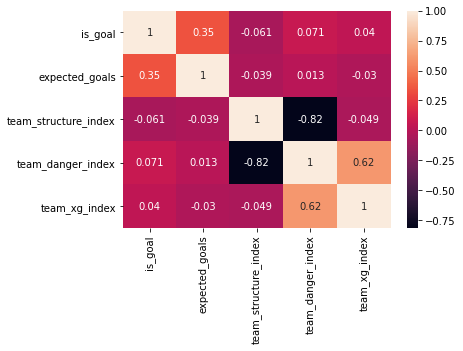

In [964]:
matrix = df_corr.corr().round(3)
sns.heatmap(matrix, annot=True)
plt.show()

## Play By Play Data Structure Index Results
- Nothing outperforms xG 
- Bringing xG into the index makes sense 
- xG Index almost as good as Danger Index (combined structure and danger index) but danger index adds additional context. 

Not changing the world but way to add context to Danger index.  

## Powerplay Danger & Structure Index with all events
- all events in the offensive zone insted of only shots because sample is too small 

(df_pbp_pp['x_coord_2'] >= O_ZONE | df_pbp_pp['x_coord_2'].isna())

In [965]:
df_pbp_player_events = pd.read_sql('''
SELECT player_name, team_name, powerplay_events, avg_x_coord, avg_y_coord, sum_distance_to_avg_shot_location, sum_distance_to_avg_shot_location / powerplay_events player_structure_index
FROM
(SELECT player_name, team_name, COUNT(player_name) powerplay_events, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, SUM(distance) sum_distance_to_avg_shot_location
FROM (
    SELECT player_name, team_name, x_coord, y_coord, avg_x_coord, avg_y_coord, SQRT((x_coord - avg_x_coord) * (x_coord - avg_x_coord) + (y_coord - avg_y_coord) * (y_coord - avg_y_coord)) distance FROM play_by_play 
LEFT JOIN (
    SELECT player_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord FROM play_by_play WHERE x_coord > 125 AND strength_state > 0 AND (x_coord_2 IS NULL OR x_coord_2 > 125) GROUP BY player_name
    )
USING (player_name)
WHERE x_coord > 125 AND strength_state > 0 AND (x_coord_2 IS NULL OR x_coord_2 > 125)
)
GROUP BY player_name
)
ORDER BY player_structure_index ASC;
''',conn)

In [966]:
df_pbp_player_events.loc[df_pbp_player_events['powerplay_events'] > 3].sort_values(by='player_structure_index', ascending=True)

,player_name,team_name,powerplay_events,avg_x_coord,avg_y_coord,sum_distance_to_avg_shot_location,player_structure_index
4,Claire Thompson,Olympic (Women) - Canada,4,138.000000,34.500000,33.082785,8.270696
6,Ella Shelton,Olympic (Women) - Canada,4,134.000000,31.500000,36.484389,9.121097
8,Erin Ambrose,Olympic (Women) - Canada,7,134.571429,50.000000,71.083888,10.154841
9,Olga Sosina,Olympic (Women) - Olympic Athletes from Russia,24,148.958333,75.666667,276.628711,11.526196
10,Sanni Rantala,Olympic (Women) - Finland,7,149.571429,67.428571,81.096722,11.585246
11,Natalie Spooner,Olympic (Women) - Canada,4,198.000000,36.500000,46.856304,11.714076
12,Brianne Jenner,Olympic (Women) - Canada,5,190.200000,31.000000,59.305330,11.861066
13,Dani Cameranesi,Olympic (Women) - United States,7,189.714286,64.000000,93.809627,13.401375
14,Sarah Nurse,Olympic (Women) - Canada,6,156.666667,42.833333,89.282317,14.880386
15,Anna Savonina,Olympic (Women) - Olympic Athletes from Russia,6,160.166667,76.000000,94.064269,15.677378


In [967]:
df_pbp_events = pd.read_sql('''
SELECT player_name, x_coord, y_coord, avg_x_coord, avg_y_coord, SQRT((x_coord - avg_x_coord) * (x_coord - avg_x_coord) + (y_coord - avg_y_coord) * (y_coord - avg_y_coord)) distance, strength_state FROM play_by_play 
LEFT JOIN (
    SELECT player_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord FROM play_by_play WHERE x_coord > 125 AND strength_state > 0 AND (x_coord_2 IS NULL OR x_coord_2 > 125) GROUP BY player_name
    )
USING (player_name)
WHERE x_coord > 125 AND strength_state > 0 AND (x_coord_2 IS NULL OR x_coord_2 > 125);
''',conn)

In [968]:
df_pbp_events_player_team = pd.read_sql('''
SELECT team_name, SUM(powerplay_shots) team_events, SUM(powerplay_shots * player_structure_index) / SUM(powerplay_shots) team_structure_index
FROM (
    SELECT player_name, team_name, powerplay_shots, avg_x_coord, avg_y_coord, sum_distance_to_avg_shot_location, sum_distance_to_avg_shot_location / powerplay_shots player_structure_index
    FROM
    (SELECT player_name, team_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, SUM(distance) sum_distance_to_avg_shot_location
    FROM (
        SELECT player_name, team_name, x_coord, y_coord, avg_x_coord, avg_y_coord, SQRT((x_coord - avg_x_coord) * (x_coord - avg_x_coord) + (y_coord - avg_y_coord) * (y_coord - avg_y_coord)) distance FROM play_by_play 
    LEFT JOIN (
        SELECT player_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord FROM play_by_play WHERE x_coord > 125 AND strength_state > 0 AND (x_coord_2 IS NULL OR x_coord_2 > 125) GROUP BY player_name
        )
    USING (player_name)
    WHERE x_coord > 125 AND strength_state > 0 AND (x_coord_2 IS NULL OR x_coord_2 > 125)
    )
    GROUP BY player_name
    )
)
GROUP BY team_name
ORDER BY team_structure_index ASC;
''',conn)

In [969]:
df_pbp_events_player_team

,team_name,team_events,team_structure_index
0,Olympic (Women) - Canada,83,17.460578
1,Olympic (Women) - Olympic Athletes from Russia,129,22.059840
2,Olympic (Women) - Finland,299,23.135644
3,Olympic (Women) - United States,196,24.042378
4,Olympic (Women) - Switzerland,189,25.436033


In [970]:
df_team_event_index = pd.read_sql('''
SELECT team_name, SUM(powerplay_shots) team_powerplay_shots, SUM(powerplay_shots * player_structure_index) / SUM(powerplay_shots) team_structure_index, SUM(powerplay_shots * player_xg_index) / SUM(powerplay_shots) team_xg_index, SUM(powerplay_shots * player_xg_index) / SUM(powerplay_shots) -  SUM(powerplay_shots * player_structure_index) / (SUM(powerplay_shots) *1000) team_danger_index
FROM (
    SELECT player_name, team_name, powerplay_shots, avg_x_coord, avg_y_coord, sum_distance_to_avg_shot_location, avg_xg, sum_distance_to_avg_shot_location / powerplay_shots player_structure_index, sum_diff_avg_xg / powerplay_shots player_xg_index, (sum_diff_avg_xg / powerplay_shots) - (sum_distance_to_avg_shot_location / (powerplay_shots * 1000)) player_danger_index
    FROM
    (SELECT player_name, team_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, SUM(distance) sum_distance_to_avg_shot_location, SUM(diff_avg_xg) sum_diff_avg_xg, avg_xg
    FROM (
        SELECT player_name, team_name, x_coord, y_coord, avg_x_coord, avg_y_coord, SQRT((x_coord - avg_x_coord) * (x_coord - avg_x_coord) + (y_coord - avg_y_coord) * (y_coord - avg_y_coord)) distance, avg_xg, diff_avg_xg 
        FROM play_by_play
    LEFT JOIN (
        SELECT player_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, AVG(non_shot_expected_goals) avg_xg, non_shot_expected_goals - AVG(non_shot_expected_goals) diff_avg_xg  FROM play_by_play WHERE x_coord > 125 AND strength_state > 0 AND (x_coord_2 IS NULL OR x_coord_2 > 125) GROUP BY player_name
        )
    USING (player_name)
    WHERE x_coord > 125 AND strength_state > 0 AND (x_coord_2 IS NULL OR x_coord_2 > 125)
    )
    GROUP BY player_name
    )
)
GROUP BY team_name
ORDER BY team_danger_index DESC;
''',conn)

In [971]:
df_team_event_index

,team_name,team_powerplay_shots,team_structure_index,team_xg_index,team_danger_index
0,Olympic (Women) - Canada,83,17.460578,-0.000574,-0.018035
1,Olympic (Women) - Olympic Athletes from Russia,129,22.059840,0.001478,-0.020582
2,Olympic (Women) - Finland,299,23.135644,0.001275,-0.021861
3,Olympic (Women) - United States,196,24.042378,-0.001502,-0.025544
4,Olympic (Women) - Switzerland,189,25.436033,-0.003320,-0.028756


In [972]:
df_player_index_non_shot = pd.read_sql('''
SELECT player_name, team_name, powerplay_shots, avg_x_coord, avg_y_coord, sum_distance_to_avg_shot_location, avg_xg, sum_distance_to_avg_shot_location / powerplay_shots player_structure_index, sum_diff_avg_xg / powerplay_shots player_xg_index, (sum_diff_avg_xg / powerplay_shots) - (sum_distance_to_avg_shot_location / (powerplay_shots * 1000)) player_danger_index
FROM
(SELECT player_name, team_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, SUM(distance) sum_distance_to_avg_shot_location, SUM(diff_avg_xg) sum_diff_avg_xg, avg_xg
FROM (
    SELECT player_name, team_name, x_coord, y_coord, avg_x_coord, avg_y_coord, SQRT((x_coord - avg_x_coord) * (x_coord - avg_x_coord) + (y_coord - avg_y_coord) * (y_coord - avg_y_coord)) distance, avg_xg, diff_avg_xg 
    FROM play_by_play
LEFT JOIN (
    SELECT player_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, AVG(non_shot_expected_goals) avg_xg, non_shot_expected_goals - AVG(non_shot_expected_goals) diff_avg_xg  FROM play_by_play WHERE x_coord > 125 AND strength_state > 0 AND (x_coord_2 IS NULL OR x_coord_2 > 125) GROUP BY player_name
    )
USING (player_name)
WHERE x_coord > 125 AND strength_state > 0 AND (x_coord_2 IS NULL OR x_coord_2 > 125)
)
GROUP BY player_name
)
ORDER BY player_danger_index DESC;
''',conn)
df_player_index

,player_name,team_name,powerplay_shots,avg_x_coord,avg_y_coord,sum_distance_to_avg_shot_location,avg_xg,player_structure_index,player_xg_index,player_danger_index
0,Michelle Karvinen,Olympic (Women) - Finland,5,160.600000,44.600000,125.287689,0.116022,25.057538,0.338378,0.087803
1,Petra Nieminen,Olympic (Women) - Finland,4,167.250000,37.500000,47.481147,0.096658,11.870287,0.110047,-0.008655
2,Elisa Holopainen,Olympic (Women) - Finland,8,159.500000,22.000000,44.291275,0.020777,5.536409,0.021792,-0.033572
3,Nina Pirogova,Olympic (Women) - Olympic Athletes from Russia,3,179.333333,47.666667,25.347867,0.119482,8.449289,0.016614,-0.067879
4,Phoebe Staenz,Olympic (Women) - Switzerland,4,165.500000,37.500000,74.141960,0.085996,18.535490,0.106481,-0.078874
5,Megan Keller,Olympic (Women) - United States,3,142.000000,33.333333,24.456078,0.020544,8.152026,0.002266,-0.079254
6,Alina Muller,Olympic (Women) - Switzerland,3,150.000000,24.333333,23.949691,0.016020,7.983230,-0.003548,-0.083380
7,Minnamari Tuominen,Olympic (Women) - Finland,11,135.363636,38.181818,125.630135,0.017259,11.420921,-0.002256,-0.116465
8,Anna Shokhina,Olympic (Women) - Olympic Athletes from Russia,6,160.500000,22.000000,78.080377,0.015175,13.013396,0.003333,-0.126801
9,Jenni Hiirikoski,Olympic (Women) - Finland,6,139.833333,47.333333,98.926297,0.034403,16.487716,0.029753,-0.135125


In [973]:
df_corr_events = pd.read_sql(
    '''
    SELECT is_goal, non_shot_expected_goals, team_structure_index, team_danger_index, team_xg_index
    FROM play_by_play
    LEFT JOIN (
        SELECT team_name, SUM(powerplay_shots) team_powerplay_shots, SUM(powerplay_shots * player_structure_index) / SUM(powerplay_shots) team_structure_index, SUM(powerplay_shots * player_xg_index) / SUM(powerplay_shots) team_xg_index, SUM(powerplay_shots * player_xg_index) / SUM(powerplay_shots) -  SUM(powerplay_shots * player_structure_index) / (SUM(powerplay_shots) *100) team_danger_index
        FROM (
            SELECT player_name, team_name, powerplay_shots, avg_x_coord, avg_y_coord, sum_distance_to_avg_shot_location, avg_xg, sum_distance_to_avg_shot_location / powerplay_shots player_structure_index, sum_diff_avg_xg / powerplay_shots player_xg_index, (sum_diff_avg_xg / powerplay_shots) - (sum_distance_to_avg_shot_location / (powerplay_shots * 100)) player_danger_index
            FROM
            (SELECT player_name, team_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, SUM(distance) sum_distance_to_avg_shot_location, SUM(diff_avg_xg) sum_diff_avg_xg, avg_xg
            FROM (
                SELECT player_name, team_name, x_coord, y_coord, avg_x_coord, avg_y_coord, SQRT((x_coord - avg_x_coord) * (x_coord - avg_x_coord) + (y_coord - avg_y_coord) * (y_coord - avg_y_coord)) distance, avg_xg, diff_avg_xg 
                FROM play_by_play
            LEFT JOIN (
                SELECT player_name, COUNT(player_name) powerplay_shots, AVG(x_coord) avg_x_coord, AVG(y_coord) avg_y_coord, AVG(non_shot_expected_goals) avg_xg, non_shot_expected_goals - AVG(non_shot_expected_goals) diff_avg_xg  FROM play_by_play WHERE x_coord > 125 AND strength_state > 0 AND (x_coord_2 IS NULL OR x_coord_2 > 125) GROUP BY player_name
                )
            USING (player_name)
            WHERE x_coord > 125 AND strength_state > 0 AND (x_coord_2 IS NULL OR x_coord_2 > 125)
            )
            GROUP BY player_name
            )
        )
        GROUP BY team_name
        ORDER BY team_danger_index DESC
    )
    USING (team_name);
    ''',conn
)

In [974]:
pearsonr(df_corr_events.iloc[(len(df_corr_events) //2)+1:,]['team_danger_index'], df_corr_events.iloc[:(len(df_corr_events) //2),]['team_danger_index'])

(0.18945811654944267, 4.72465215975818e-44)

In [975]:
pearsonr(df_corr_events.iloc[2::2, :]['team_danger_index'], df_corr_events.iloc[1::2, :]['team_danger_index'])

(0.6431486817618668, 0.0)

In [976]:
pearsonr(df_corr_events.iloc[2::2, :]['team_structure_index'], df_corr_events.iloc[1::2, :]['team_structure_index'])

(0.6552230431673768, 0.0)

In [977]:
df_corr_events.shape

(10609, 5)

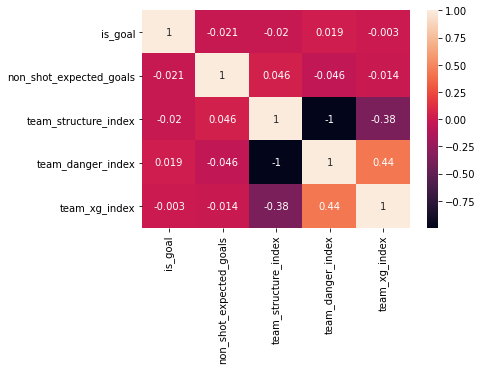

In [978]:
matrix_events = df_corr_events.corr().round(3)
sns.heatmap(matrix_events, annot=True)
plt.show()

In [979]:
df_corr_test = pd.read_sql('''
SELECT expected_goals, non_shot_expected_goals, is_goal FROM play_by_play
''',conn)

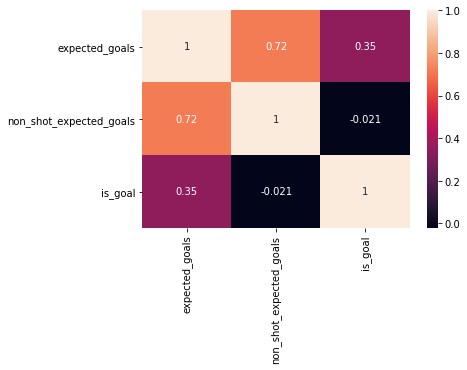

In [980]:
matrix_test = df_corr_test.corr().round(3)
sns.heatmap(matrix_test, annot=True)
plt.show()

Using the non-shot-xg-model hurts predictability a lot so maybe there is some middle ground: xg_index from only Shots, and powerplay_structure_index from all events.